In [1]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install yfinance
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
df_stats = pd.read_csv("stock_data.csv")
df_hist = pd.read_csv("historical_data.csv", header = [0, 1], index_col = 0, parse_dates = True)
df_hist = df_hist.xs("Close", axis = 1, level = 1)

In [4]:
df_stats.head()

,Symbol,Price,Change %,Volume,Rel Volume,Market cap,P/E,EPS dil TTM,EPS dil growth TTM YoY,Div yield % TTM,Sector,Analyst Rating,P/B
0,CVX,160.76,-0.41%,6076000000,0.76,2889000000000,17.69,9.09,-32.44%,3.96%,Energy minerals,Buy,1.85
1,COP,113.76,+1.28%,5089000000,0.95,130928000000000,13.51,8.42,-8.01%,2.60%,Energy minerals,Buy,2.62
2,EOG,136.54,+1.47%,3061000000,1.01,76797000000000,10.99,12.42,-7.71%,3.82%,Energy minerals,Buy,2.61
3,PSX,131.32,+0.31%,2357000000,0.99,54234000000000,16.89,7.78,-53.08%,3.36%,Energy minerals,Buy,1.89
4,FANG,181.90,+3.00%,1968000000,0.88,53113000000000,10.42,17.46,-0.96%,6.09%,Energy minerals,Buy,1.42


In [5]:
df_hist.head()

Ticker,CRGY,TALO,CEIX,DVN,CTRA,APA,CNX,EOG,HCC,SM,...,IEP,VLO,AR,MTDR,FANG,MPC,VNOM,EQT,COP,RRC
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-08 00:00:00+00:00,16.820000,10.87,21.870001,44.910000,20.750000,26.629999,14.27,90.080002,23.190001,31.940001,...,50.770000,70.720001,17.219999,41.540001,113.629997,64.059998,22.270000,20.969999,74.110001,18.850000
2021-12-09 00:00:00+00:00,16.379999,10.29,21.190001,42.320000,20.820000,26.030001,14.25,88.879997,23.299999,31.540001,...,50.230000,70.309998,17.240000,40.430000,110.330002,63.340000,21.760000,20.709999,72.550003,18.990000
2021-12-10 00:00:00+00:00,16.000000,10.00,21.350000,43.419998,20.910000,26.670000,14.57,89.680000,22.490000,32.759998,...,50.099998,70.849998,17.410000,39.639999,111.180000,63.689999,21.620001,20.860001,73.489998,19.290001
2021-12-13 00:00:00+00:00,14.930000,9.61,20.510000,41.060001,20.459999,25.280001,13.93,88.029999,20.709999,30.180000,...,50.000000,68.220001,16.600000,37.180000,106.610001,61.810001,21.030001,20.120001,71.019997,18.459999
2021-12-14 00:00:00+00:00,14.500000,9.73,20.670000,40.340000,20.090000,24.950001,13.89,85.300003,21.230000,29.219999,...,49.720001,68.190002,16.320000,36.720001,104.070000,62.450001,20.540001,21.270000,70.680000,18.010000


In [6]:
"""

Call if you want to redownload data with different tickers or time range

tickers = df_stats["Symbol"].map(lambda x: x.split(" ")[0])
df_hist = yf.download(list(tickers.values), period = "max", interval = "1d", group_by = "tickers")
df_hist.dropna(inplace = True)
df_hist.to_csv("historical_data.csv")

"""

'\n\nCall if you want to redownload data with different tickers or time range\n\ntickers = df_stats["Symbol"].map(lambda x: x.split(" ")[0])\ndf_hist = yf.download(list(tickers.values), period = "max", interval = "1d", group_by = "tickers")\ndf_hist.dropna(inplace = True)\ndf_hist.to_csv("historical_data.csv")\n\n'

In [7]:
#using cboe 30 year treasury yield index as a proxy for risk free rate
#remember to divide by 252 (# of trading days in a year) to make daily risk free rate

#daily_risk_free_rate = yf.download("^TYX", period = "max", interval = "1d", group_by = "tickers").iloc[-len(df_hist):] / 252
#daily_risk_free_rate.to_csv("risk_free.csv")

daily_risk_free_rate = pd.read_csv("risk_free.csv", header = [0, 1], index_col = 0, parse_dates = True)
daily_risk_free_rate = daily_risk_free_rate.xs("Close", axis = 1, level = 1)["^TYX"]

In [8]:
df_hist.columns

Index(['CRGY', 'TALO', 'CEIX', 'DVN', 'CTRA', 'APA', 'CNX', 'EOG', 'HCC', 'SM',
       'MGY', 'EXE', 'HES', 'HESM', 'BTU', 'MRO', 'NFG', 'PR', 'OVV', 'ARCH',
       'AMR', 'DINO', 'NOG', 'ARLP', 'CIVI', 'MUR', 'GPOR', 'CHRD', 'CRK',
       'CRC', 'CVX', 'PSX', 'OXY', 'PBF', 'IEP', 'VLO', 'AR', 'MTDR', 'FANG',
       'MPC', 'VNOM', 'EQT', 'COP', 'RRC'],
      dtype='object', name='Ticker')

In [25]:
#some data engineering to create the fama 3 data

#pick some energy company, entirely up to you, just pick from above
asset = "CRGY"

df_fama_3 = pd.DataFrame()
df_fama_3.index = df_hist.index[1:]

#subtract R_f from R_m (the average return of our entire portfolio, which I've designated as market) - feel free to pull better data ^SNP or ^IXIC if youd like
df_fama_3["Mkt_Returns"] = df_hist.pct_change()[1:].mean(axis = 1) - daily_risk_free_rate
df_fama_3["Asset_Returns"] = df_hist[asset].pct_change()[1:].mean() - daily_risk_free_rate

#top N percent, and bottom N percent
mkt_cap_threshold = .3

top_n_mkt_cap = df_stats["Symbol"][df_stats["Market cap"] > df_stats["Market cap"].quantile(1 - mkt_cap_threshold)]
bot_n_mkt_cap = df_stats["Symbol"][df_stats["Market cap"] < df_stats["Market cap"].quantile(mkt_cap_threshold)]

df_fama_3["SMB"] = df_hist[bot_n_mkt_cap].pct_change()[1:].mean(axis = 1) - df_hist[top_n_mkt_cap].pct_change()[1:].mean(axis = 1)

#try coding HML, we will go over together (note, book-to-market = 1 / price-to-book)

#:)

df_stats["BookToMarket"] = 1 / df_stats["P/B"]

top_n_mkt_cap = df_stats["Symbol"][df_stats["BookToMarket"] > df_stats["BookToMarket"].quantile(1 - mkt_cap_threshold)]
bot_n_mkt_cap = df_stats["Symbol"][df_stats["BookToMarket"] < df_stats["BookToMarket"].quantile(mkt_cap_threshold)]

df_fama_3["HML"] = df_hist[bot_n_mkt_cap].pct_change()[1:].mean(axis = 1) - df_hist[top_n_mkt_cap].pct_change()[1:].mean(axis = 1)

df_fama_3["time"] = df_hist.index.map(lambda x: x.toordinal())[1:]
df_fama_3["time2"] = df_fama_3["time"]**2

In [26]:
df_fama_3 -= df_fama_3.min()
df_fama_3 /= df_fama_3.max()

In [27]:
df_fama_3.head()

,Mkt_Returns,Asset_Returns,SMB,HML,time,time2
Date,,,,,,
2021-12-09 00:00:00+00:00,0.534354,0.983592,0.460168,0.718949,0.000000,0.000000
2021-12-10 00:00:00+00:00,0.670525,0.978122,0.319783,0.497765,0.000930,0.000930
2021-12-13 00:00:00+00:00,0.405745,1.000000,0.595585,0.848381,0.003721,0.003718
2021-12-14 00:00:00+00:00,0.589643,0.998177,0.525200,0.631084,0.004651,0.004648
2021-12-15 00:00:00+00:00,0.680112,0.986934,0.702822,0.701414,0.005581,0.005577


In [28]:
training_pct = .8
training_index = int(len(df_fama_3) * training_pct)

df_train = df_fama_3[:training_index]
df_test = df_fama_3[training_index:]

In [29]:
import statsmodels.formula.api as smf

model = smf.ols("Asset_Returns ~ Mkt_Returns + SMB + HML + time + time2", df_train)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          Asset_Returns   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     880.7
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          9.22e-270
Time:                        22:25:46   Log-Likelihood:                 651.62
No. Observations:                 592   AIC:                            -1291.
Df Residuals:                     586   BIC:                            -1265.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9202      0.035     25.923      

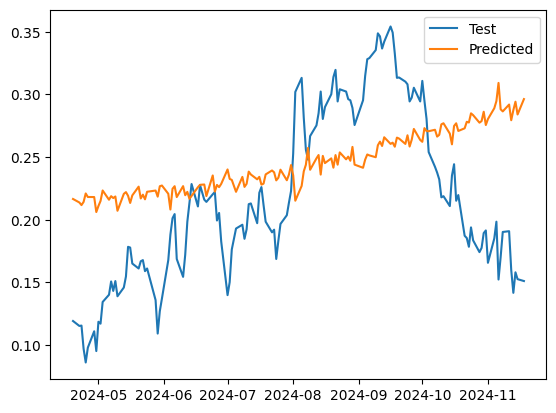

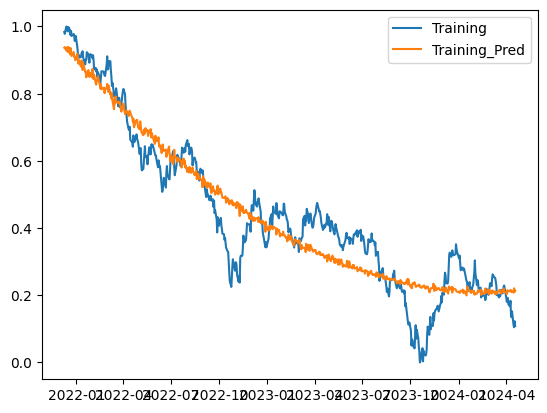

In [30]:
plt.plot(df_test["Asset_Returns"], label = "Test")
plt.plot(result.predict(df_test), label = "Predicted")

plt.legend()
plt.show()

plt.plot(df_train["Asset_Returns"], label = "Training")
plt.plot(result.predict(df_train), label = "Training_Pred")

plt.legend()
plt.show()